In [1]:
import cvtk
import os
import sys
nb_dir = os.path.split(os.getcwd())[0]
if nb_dir not in sys.path:
    sys.path.append(nb_dir)
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

import re
import pickle

from tqdm import tnrange
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import statsmodels.api as sm
import matplotlib as mpl

In [2]:
from cvtk.cvtk import TemporalFreqs, TiledTemporalFreqs
from cvtk.cov import stack_temporal_covariances
import cvtk.variant_files as vf
from cvtk.gintervals import GenomicIntervals
from cvtk.pca import FreqPCA
from cvtk.plots import rep_plot_pca, correction_diagnostic_plot
from cvtk.utils import integerize
from cvtk.utils import extract_empirical_nulls_diagonals, extract_temporal_cov_diagonals
from cvtk.cov import stack_replicate_covariances, stack_temporal_covs_by_group

/gxfs_home/geomar/smomw504/miniconda3/envs/cvtk/lib/python3.9/site-packages/cvtkpy-0.0.1-py3.9.egg/cvtk/gintervals.py:138: SyntaxWarning: "is not" with a literal. Did you mean "!="?
/gxfs_home/geomar/smomw504/miniconda3/envs/cvtk/lib/python3.9/site-packages/cvtkpy-0.0.1-py3.9.egg/cvtk/gintervals.py:138: SyntaxWarning: "is not" with a literal. Did you mean "!="?


In [3]:
%matplotlib inline
#%config InlineBackend.figure_format = 'svg'
mpl.rcParams['figure.figsize'] = (8.0, 4.0)
mpl.rcParams['figure.dpi'] = 200

In [4]:
np.random.seed(0)

In [5]:
from cvtk.variant_files import VCFFile

#vcf = VCFFile('/gxfs_home/geomar/smomw504/cod/cod.500k.vcf')
vcf = VCFFile('/gxfs_work1/geomar/smomw426/cod_all_5_115/09_selectVariants/cod_all_5_115_filteredSNPs_gq20_dp8_ua_miss0.9_maf0.05_hwe001_bial.recode.vcf.gz')

reading file '/gxfs_work1/geomar/smomw426/cod_all_5_115/09_selectVariants/cod_all_5_115_filteredSNPs_gq20_dp8_ua_miss0.9_maf0.05_hwe001_bial.recode.vcf.gz'...
file '/gxfs_work1/geomar/smomw426/cod_all_5_115/09_selectVariants/cod_all_5_115_filteredSNPs_gq20_dp8_ua_miss0.9_maf0.05_hwe001_bial.recode.vcf.gz' loaded.
total time to load VCF file: 0.5998849670092264 mins.


In [6]:
samples = pd.read_csv("/gxfs_work1/geomar/smomw426/cod_all_5_115/15_temp_cov/pop_info", header=None, names = ('individual', 'line'), sep="\t")
samples

,individual,line
0,4-04-AL099-630_S4_L004,pop1996
1,20-20-AL101-185_S20_L004,pop1996
2,22-22-AL099-591_S22_L004,pop1996
3,25-25-AL101-434_S25_L004,pop1996
4,26-26-AL101-504_S26_L004,pop1996
...,...,...
110,J35421-S1-_L1_S118_L002,pop2019
111,J35422-S1-_L1_S119_L002,pop2019
112,J35429-S1-_L1_S126_L002,pop2019
113,J35430-S1-_L1_S127_L002,pop2019


In [7]:
sample_map = {k:v for k, v in zip(samples['individual'], samples['line'])}
sample_map

{'4-04-AL099-630_S4_L004': 'pop1996',
 '20-20-AL101-185_S20_L004': 'pop1996',
 '22-22-AL099-591_S22_L004': 'pop1996',
 '25-25-AL101-434_S25_L004': 'pop1996',
 '26-26-AL101-504_S26_L004': 'pop1996',
 '38-38-AL099-597_S38_L004': 'pop1996',
 '47-47-AL099-600_S47_L004': 'pop1996',
 '61-61-AL099-621_S7_L004': 'pop1996',
 '65-65-AL099-344_S11_L004': 'pop1996',
 '69-69-AL101-595_S15_L004': 'pop1996',
 '70-70-AL101-105_S16_L004': 'pop1996',
 '77-77-AL101-430_S23_L004': 'pop1996',
 '79-79-AL099-369_S25_L004': 'pop1996',
 '99-99-AL101-114_S45_L004': 'pop1996',
 '100-100-AL099-577_S46_L004': 'pop1996',
 'J32532': 'pop1996',
 'J32534': 'pop1996',
 'J32535': 'pop1996',
 'J32536': 'pop1996',
 'J32537': 'pop1996',
 'J32538': 'pop1996',
 'J32542': 'pop1996',
 'J32543': 'pop1996',
 'J32544': 'pop1996',
 'J32545': 'pop1996',
 'J32546': 'pop1996',
 'J32547': 'pop1996',
 'J32533-_L1_S2_L001': 'pop1996',
 'J32539-_L1_S8_L001': 'pop1996',
 '16-16-AL207-504_S16_L004': 'pop2002',
 '29-29-AL207-561_S29_L004': 

In [8]:
from collections import defaultdict

subpop_indices = defaultdict(list)
for i, k in enumerate(vcf.samples):
    subpop_indices[sample_map[k.decode()]].append(i)

subpop_indices

defaultdict(list,
            {'pop2008': [0,
              1,
              4,
              5,
              9,
              10,
              12,
              13,
              15,
              21,
              22,
              24,
              25,
              29,
              30,
              31,
              35,
              39,
              40,
              43,
              47,
              51,
              54,
              57],
             'pop1996': [2,
              14,
              16,
              17,
              18,
              26,
              27,
              32,
              42,
              44,
              46,
              48,
              52,
              53,
              60,
              61,
              62,
              63,
              64,
              65,
              66,
              67,
              68,
              69,
              70,
              71,
              72,
              73,
              74],
          

From this, we can map the vcf.geno_mat table to subpopulation counts.

In [9]:
counts_mat = vcf.count_alleles_subpops(subpop_indices)
counts_mat['pop2008']

/gxfs_home/geomar/smomw504/miniconda3/envs/cvtk/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3361: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)


<AlleleCountsArray shape=(1037437, 2) dtype=int32>
42  4
40  4
43  3
...
33  9
41  3
41  3

In [10]:
vcf.subpops

dict_keys(['pop2008', 'pop1996', 'pop2002', 'pop2014', 'pop2019'])

Now we count the number of diploids in each sample.

In [11]:
from collections import Counter

ndiploids = [Counter(sample_map.values())[k] for k in vcf.subpops]
ndiploids

[24, 29, 22, 20, 20]

In [12]:
#design = [ ('pop1996',1),
#            ('pop2002',1),
#            ('pop2008',1),
#            ('pop2014',1),
#            ('pop2019',1) ]

In [13]:
design = [  ('pop',1),
            ('pop',2),
            ('pop',3),
            ('pop',4),
            ('pop',5) ]

In [14]:
freq_mat_all = vcf.calc_freqs()
print("number of loci: ", freq_mat_all.shape[1])

number of loci:  1037437


In [15]:
vcf.remove_fixed()
freq_mat = vcf.calc_freqs()
print("number of loci: ", freq_mat.shape[1])
#number of loci:  1037437
print("loci not segregating removed: ", freq_mat_all.shape[1] - freq_mat.shape[1])
#loci not segregating removed:  0

number of loci:  1037437
loci not segregating removed:  0


In [16]:
gi = vcf.build_gintervals()
gi

GenomicIntervals — 24 unique seqids, 1037437 features
     GenomicInterval
0    LG01:[478, 479)
1    LG01:[524, 525)
2    LG01:[664, 665)
3  LG01:[2017, 2018)
4  LG01:[2688, 2689)
[ 1037432 more GenomicIntervals ]

## Covariance Analysis

In [72]:
tile_width = 10e5
gi.infer_seqlens()
tiles = GenomicIntervals.from_tiles(gi.seqlens, width=tile_width)

In [73]:
d = TiledTemporalFreqs(tiles, freqs=freq_mat, depths=vcf.N, diploids=ndiploids, samples=design, gintervals=gi)
d.freqs.shape

(1, 5, 1037437)

In [74]:
d.samples

[('pop', 1), ('pop', 2), ('pop', 3), ('pop', 4), ('pop', 5)]

In [75]:
np.amax(d.depths.flatten())

58

In [76]:
np.amin(d.depths.flatten())

24

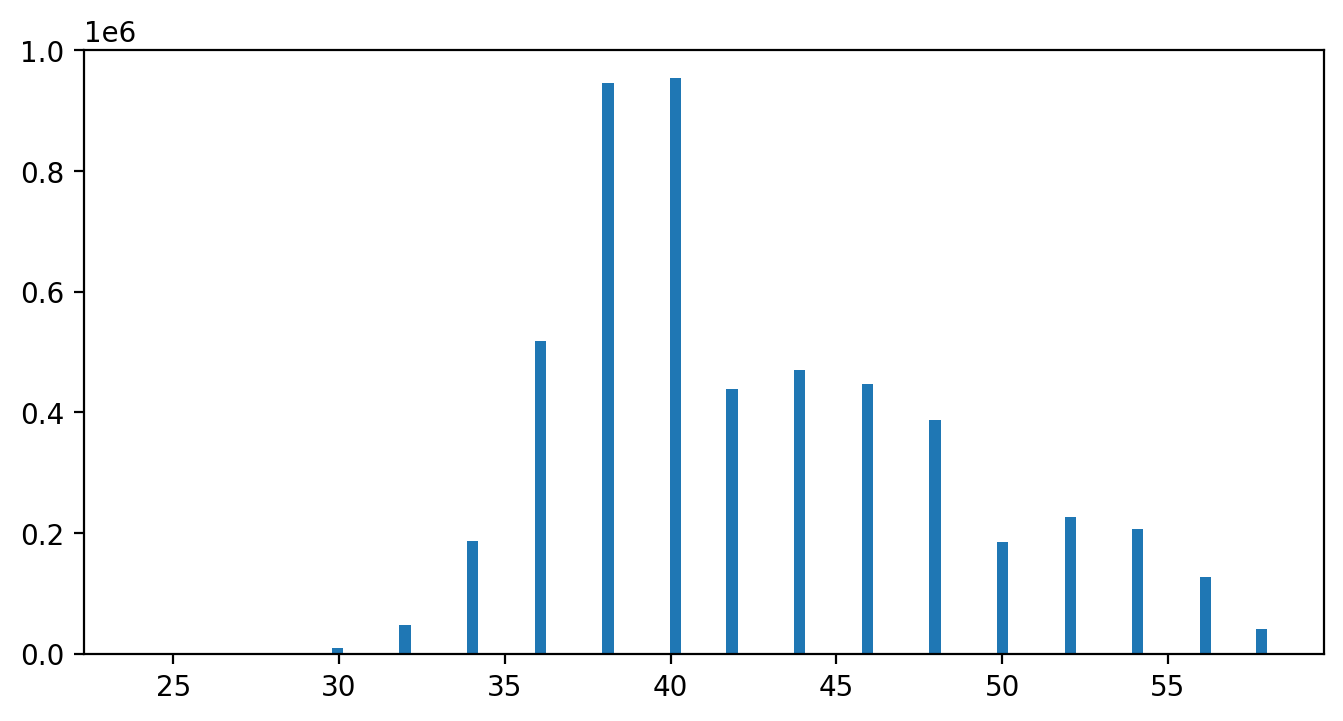

In [77]:
plt.hist(d.depths.flatten(),100)
plt.show()

In [78]:
d.freqs.shape

(1, 5, 1037437)

How many windows and what's the mean and median number of loci per window?

In [79]:
nloci = np.array([len(x) for x in d.tile_indices])

d_noempty = [ele for ele in d.tile_indices if ele != []]
print(len(d_noempty))
print(len(d.tile_indices))

print(f"mean number of loci: {nloci.mean()}")
print(f"median number of loci: {np.median(nloci)}")

635
635
mean number of loci: 1623.1354330708662
median number of loci: 1697.0


In [80]:
nloci

array([ 899, 1356, 1622, 2354, 2434, 1524, 2127, 1766, 2184, 1192, 1159,
       1707, 1706, 1979, 1178, 1312, 1454, 2001, 1716, 1886, 1341, 1672,
       1316,  820,  875, 1353, 1676, 1213, 1618, 1713, 2124, 2212, 1490,
       1518,  803, 1376, 2376, 1594, 2411, 2679, 1700, 2253, 1753, 1406,
       2511, 1901, 1779, 2484, 2436, 2415,  744, 1840,  912,  670, 1373,
       1382, 1232, 2458, 2495, 2068, 1553, 1002, 1651, 1815, 1999, 2015,
       1150, 1330, 2134, 1823, 1309, 1661, 1985, 1630, 2393, 2132, 2127,
       1567, 1388, 1845,  453, 1175,  576, 1378, 2015, 1985, 1904, 1757,
       2096, 1974, 1404,  915,  230,  579,  691, 1160, 1780, 1923, 2026,
       2222, 1835, 1729, 2224, 2237, 2827, 2441, 1980, 2256, 1731, 2071,
       1777, 1752, 1200, 2142, 1162,  702,  468, 1861, 1615,  967, 2646,
       1672, 2178, 1721, 2175, 1840, 1775, 1401, 2148, 2490, 2449, 1697,
       2519, 2530, 2077, 1702, 1066, 1061,  860,  929, 1272,  670, 1072,
       2285, 2378, 2222, 3269, 2551, 2549, 2144, 19

In [81]:
#gw_covs = d.calc_cov(use_masked=True, standardize=True)
gw_covs = d.calc_cov()

In [82]:
gw_covs.shape

(4, 4)

<ipython-input-83-81cb7ab2e0aa>:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(sample_names)
<ipython-input-83-81cb7ab2e0aa>:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(sample_names)


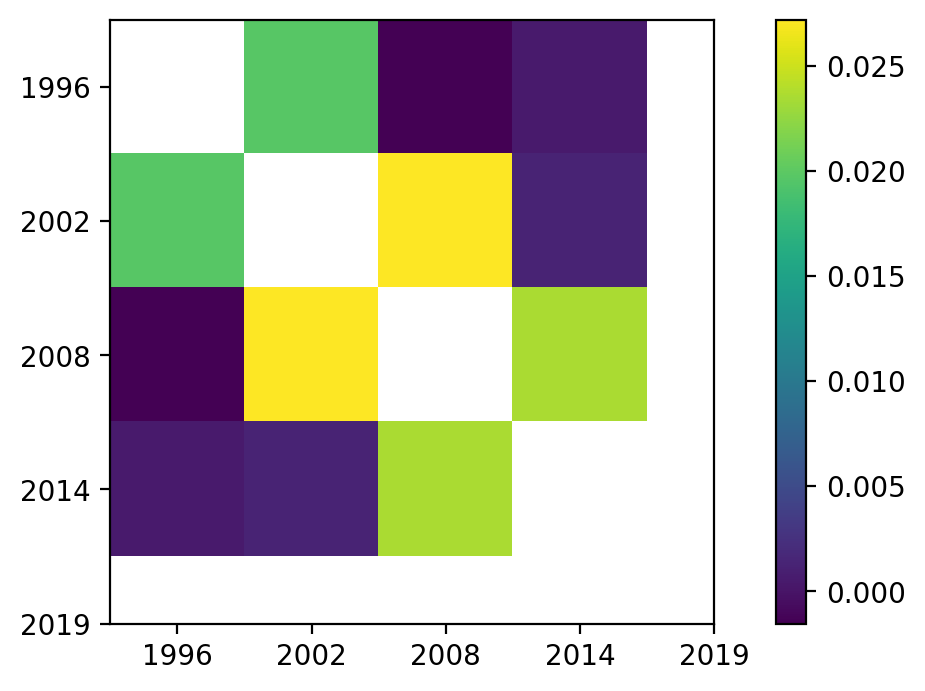

In [83]:
np.fill_diagonal(gw_covs, np.nan)
fig, ax = plt.subplots()
ax.imshow(gw_covs)
img1 = ax.imshow(gw_covs)
fig.colorbar(img1, ax=ax)
sample_names = ['1996','2002','2008','2014','2019' ]
ax.set_xticklabels(sample_names)
ax.set_yticklabels(sample_names)
#print( design['name'])
ax.set_xticks(np.arange(len(sample_names)))
ax.set_yticks(np.arange(len(sample_names)))
#plt.savefig('/users/r/b/rbrennan/tonsa_genomics/figures/covariance_heatmap.pdf')

plt.show()

In [84]:
#bootstrap covariance matrix
from tqdm import tqdm
from tqdm import tnrange
# need to use CI method "standard" to deal with bias in the bootstrap
gw_covs_cis = d.bootstrap_cov(B=1000, progress_bar=True, keep_seqids=None,
                              average_replicates=False, use_masked=True)
#ci_method="standard"

bootstraps:   0%|          | 0/1000 [00:00<?, ?it/s]

In [85]:
rows, cols = np.triu_indices(gw_covs_cis.shape[1], k=1)
lower, mean, upper = [gw_covs_cis[i, rows, cols].ravel() for i in np.arange(3)]
print(lower)
print(mean)
print(upper)

[ 0.01932499 -0.00229464 -0.00011704  0.02677878  0.00068724  0.02289909]
[ 0.01977312 -0.00154404  0.00049895  0.0271981   0.00126295  0.023565  ]
[ 0.02019535 -0.00064072  0.00109806  0.02752855  0.00176335  0.02426256]


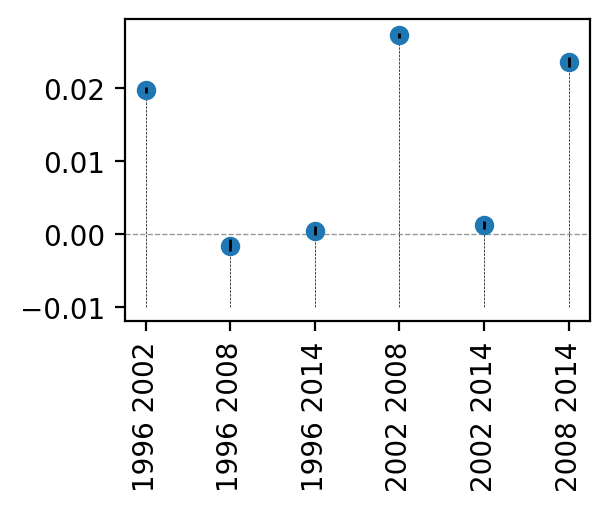

In [88]:
def rep_cov_plot(cis, labels='', filename=''):
    rows, cols = np.triu_indices(cis.shape[1], k=1)
    lower, mean, upper = [cis[i, rows, cols].ravel() for i in np.arange(3)]
    all_labels = [labels[i] + " " + labels[j] for i, j in zip(rows, cols)]
    lower, upper = mean-lower, upper-mean
    bounds = np.stack([lower, upper])
    plt.figure(figsize=(3,2)) 
    plt.axhline(y=0, c='0.6', linewidth=0.5, zorder=-1, linestyle='--')
    plt.xticks(rotation='vertical',fontsize=10)
    markerline, stemline, baseline, = plt.stem(all_labels, mean,linefmt='k--', bottom = -0.01)
    plt.setp(stemline, linewidth = 0.25)
    plt.setp(baseline, 'linewidth', 0)
    #plt.ylim([-0.01, 0.065])
    #plt.errorbar(all_labels, mean, yerr=bounds, capsize=0, fmt='o', linewidth=1.5, elinewidth=2)
    plt.errorbar(all_labels, mean, yerr=bounds, capsize=0, fmt='none', linewidth=1, elinewidth=1, ecolor = "black")
    plt.savefig(filename, bbox_inches='tight')

sample_names = ['1996','2002','2008','2014','2019' ]
rep_cov_plot(gw_covs_cis, sample_names,"./covariance_pairwise.pdf")


## bias correction

In [39]:
diagnostics = d.correction_diagnostics(exclude_seqids=None)

/gxfs_home/geomar/smomw504/miniconda3/envs/cvtk/lib/python3.9/site-packages/cvtkpy-0.0.1-py3.9.egg/cvtk/cvtk.py:260: RuntimeWarning: Mean of empty slice
/gxfs_home/geomar/smomw504/miniconda3/envs/cvtk/lib/python3.9/site-packages/cvtkpy-0.0.1-py3.9.egg/cvtk/cvtk.py:274: RuntimeWarning: Mean of empty slice
/gxfs_home/geomar/smomw504/miniconda3/envs/cvtk/lib/python3.9/site-packages/numpy-1.22.3-py3.9-linux-x86_64.egg/numpy/lib/function_base.py:495: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/gxfs_home/geomar/smomw504/miniconda3/envs/cvtk/lib/python3.9/site-packages/numpy-1.22.3-py3.9-linux-x86_64.egg/numpy/core/_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
/gxfs_home/geomar/smomw504/miniconda3/envs/cvtk/lib/python3.9/site-packages/cvtkpy-0.0.1-py3.9.egg/cvtk/cov.py:348: RuntimeWarning: Degrees of freedom <= 0 for slice
/gxfs_home/geomar/smomw504/miniconda3/envs/cvtk/lib/python3.9/site-packages/numpy-1.22.3-py3.9-linux-x86_

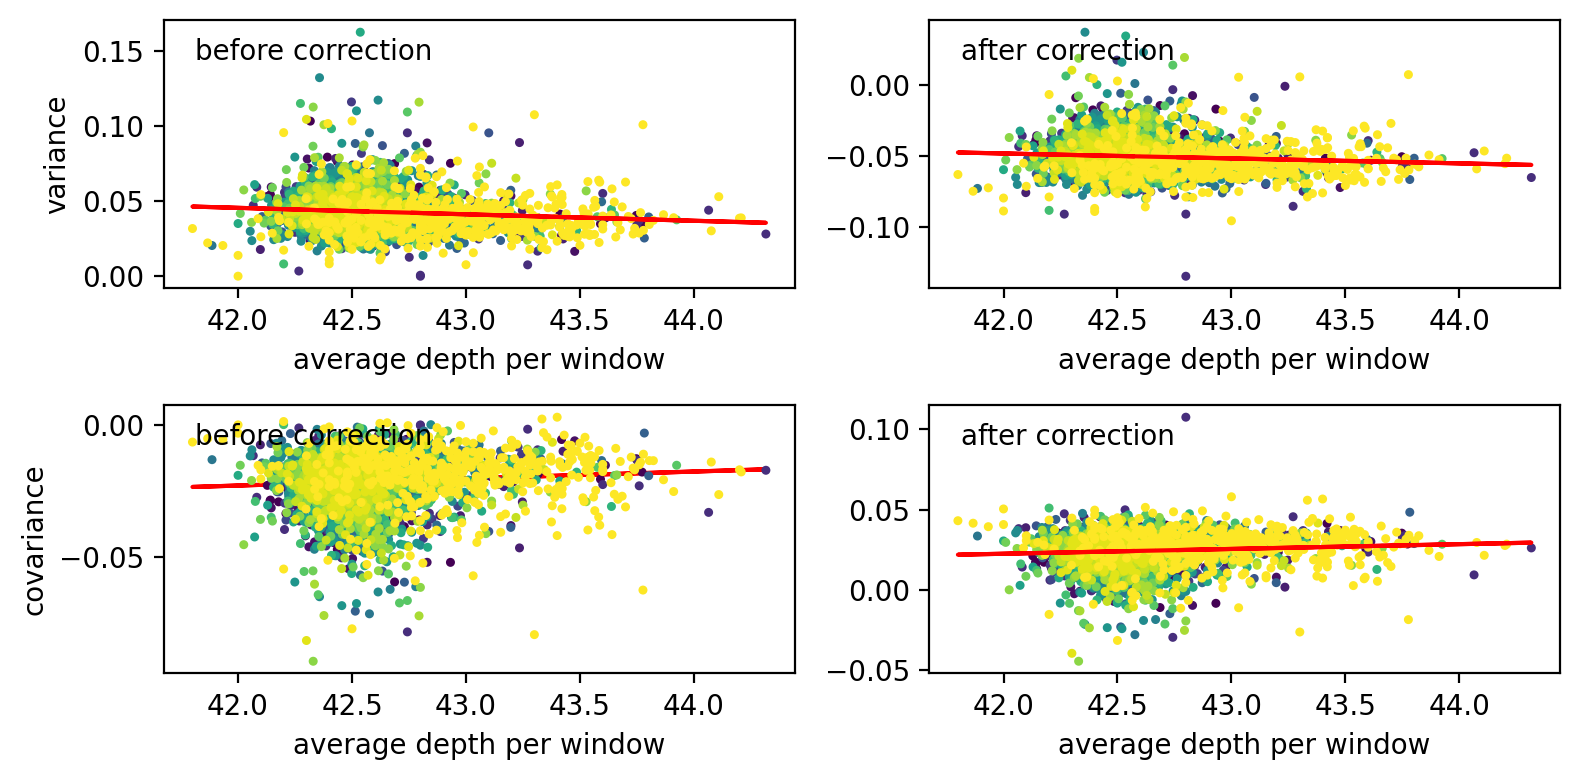

In [41]:
# _ = correction_diagnostic_plot(diagnostics, color=False)
# diagnostic plot from package threw error.
def correction_diagnostic_plot(diag, figsize=None, color=True):
    corr_df, models, xpreds, ypreds = diag
    if figsize is not None:
        fig, ax = plt.subplots(ncols=2, nrows=2, figsize=figsize)
    else:
        fig, ax = plt.subplots(ncols=2, nrows=2)
    labelx, labely = 0.05, 0.85
    before = corr_df[corr_df['correction'] == False]
    after = corr_df[corr_df['correction'] == True]
    if color:
        ax[0, 0].scatter(before['depth'], before['diag'], c=integerize(before['seqid']), s=5)
        ax[0, 1].scatter(before['depth'], after['diag'], c=integerize(before['seqid']), s=5)
    else:
        ax[0, 0].scatter(before['depth'], before['diag'], s=5)
        ax[0, 1].scatter(before['depth'], after['diag'], s=5)
    ax[0, 0].plot(xpreds[False], ypreds[False][0], 'r-')
    ax[0, 1].plot(xpreds[True], ypreds[True][0], 'r-')
    ax[0, 0].annotate('before correction', xy=(labelx, labely), xycoords='axes fraction')
    ax[0, 0].set_ylabel('variance')
    ax[0, 0].set_xlabel('average depth per window')
    ax[0, 1].set_xlabel('average depth per window')
    ax[0, 1].annotate('after correction', xy=(labelx, labely), xycoords='axes fraction')

    ax[1, 0].plot(xpreds[False], ypreds[False][1], 'r-')
    ax[1, 0].annotate('before correction', xy=(labelx, labely), xycoords='axes fraction')
#    ax[1, 0].axhline(y=0, color='99', zorder=1, linestyle='--')
    ax[1, 0].set_ylabel('covariance')
    if color:
        ax[1, 0].scatter(before['depth'], before['offdiag'], c=integerize(before['seqid']),
                         zorder=2, s=5)
        ax[1, 1].scatter(before['depth'], after['offdiag'], c=integerize(before['seqid']),
                         zorder=2, s=5)
    else:
        ax[1, 0].scatter(before['depth'], before['offdiag'], zorder=2, s=5)
        ax[1, 1].scatter(before['depth'], after['offdiag'], zorder=2, s=5)
    ax[1, 1].plot(xpreds[True], ypreds[True][1], 'r-')
    ax[1, 1].annotate('after correction', xy=(labelx, labely), xycoords='axes fraction')
 #   ax[1, 1].axhline(y=0, color='99', zorder=1, linestyle='--')
    ax[1, 0].set_xlabel('average depth per window')
    ax[1, 1].set_xlabel('average depth per window')
    plt.tight_layout()
    return fig, ax

_ = correction_diagnostic_plot(diagnostics, color=True)

## convergent corr

In [54]:
d.bootstrap_convergence_corr(B=100, progress_bar=False, subset=(0, 1), ci_method='standard')

ValueError: cannot reshape array of size 16 into shape (8,8)

In [47]:
import itertools
from cvtk.bootstrap import block_bootstrap

combs = list(itertools.combinations(range(0,4),2))

outlist = []

for x in combs:
    outlist.append(
                    d.bootstrap_convergence_corr(B=1000, 
                                                 progress_bar=False, subset=(x[0], x[1]),
                                                 ci_method='standard'))
    print("done with rep", x)

ValueError: cannot reshape array of size 16 into shape (8,8)

In [49]:
def convergence_corr(self, subset=None, bias_correction=True, **kwargs):
        gw_covs = self.calc_cov(standardize=False,
                                bias_correction=bias_correction, **kwargs)
        if subset is not None:
            rows, cols = replicate_block_matrix_indices(self.R, self.T)
            rows_keep, cols_keep = np.isin(rows, subset), np.isin(cols, subset)
            dim = self.T * len(subset)
            gw_covs = gw_covs[np.logical_and(rows_keep, cols_keep)].reshape((dim, dim))

        R = self.R if subset is None else len(subset)
        return convergence_corr(gw_covs, R, self.T)

def calc_cov(self, keep_seqids=None, bias_correction=True,
                standardize=True, use_masked=False, product_only=False):
        """
        Calculate the genome-wide temporal-replicate variance-covariance matrix.
        If keep_seqids=None, all seqids are used in the calculation of the covariance.
        Otherwise, if it's a list of seqids, only these are used.
        """
        freqs, depths = self.freqs, self.depths
        if keep_seqids is not None:
            assert(isinstance(keep_seqids, (tuple, list)))
            idx = np.array([i for i, seqid in enumerate(self.gintervals.seqid)
                            if seqid in keep_seqids])
            freqs, depths = freqs[..., idx], depths[..., idx]
        return temporal_replicate_cov(freqs, depths, self.diploids,
                                      bias_correction=bias_correction,
                                      share_first=self.share_first,
                                      product_only=product_only,
                                      standardize=standardize, use_masked=use_masked)

In [50]:
d.convergence_corr()

ValueError: need at least one array to stack